In [1]:
%reset -f

In [2]:
import plotting
from pyseis.wave_equations import elastic_isotropic, acoustic_isotropic
from pyseis.wavelets.elastic import Elastic2D
from pyseis.wavelets.acoustic import Acoustic2D
from pyseis import inversion
%matplotlib inline

WARNING! DATAPATH not found. The folder /tmp will be used to write binary files


In [3]:
import os
import math
pwd = os.getcwd()
%env DATAPATH={pwd}/wrk/

env: DATAPATH=/home/test01/App/01_PySeis/xu/TASK6_DAS_DATA/Data/ForwardModeling/wrk/


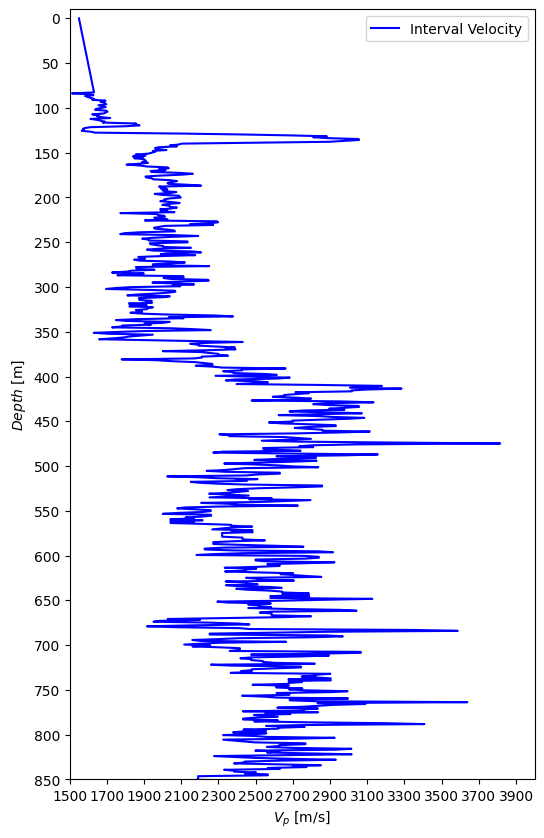

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Load the log data from the CSV file in the current directory
file_path = 'Curtin_DAS_VSP_Sonic_modified.csv'  # CSV file in the current folder
df = pd.read_csv(file_path)

# Extract depth and interval velocity from the loaded data
depths = df['Depth (DAS)'].values
interval_velocities = df['interval velocity'].values

# Plot settings
depmin, depmax, depstep = -10, 850, 50
vmin, vmax, vstep = 1500, 4000, 200

# Plotting the data
fig = plt.figure(figsize=(6, 10))
ax1 = fig.add_subplot(1,1,1)

# Plot interval velocities (original only, no interpolation)
ax1.plot(interval_velocities, depths, lw=1.5, color='blue', label='Interval Velocity')

# Label and format the plot
ax1.set_xlabel('$V_p$ [m/s]')
ax1.set_ylabel('$Depth$ [m]')
ax1.set_xlim(vmin, vmax)
ax1.set_ylim(depmax, depmin)  # depth increases downward
ax1.set_xticks(np.arange(vmin, vmax, vstep))
ax1.set_yticks(np.arange(depmax, depmin, -depstep))
ax1.legend()

plt.show()


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:24: RuntimeWarning: divide by zero encountered in double_scalars


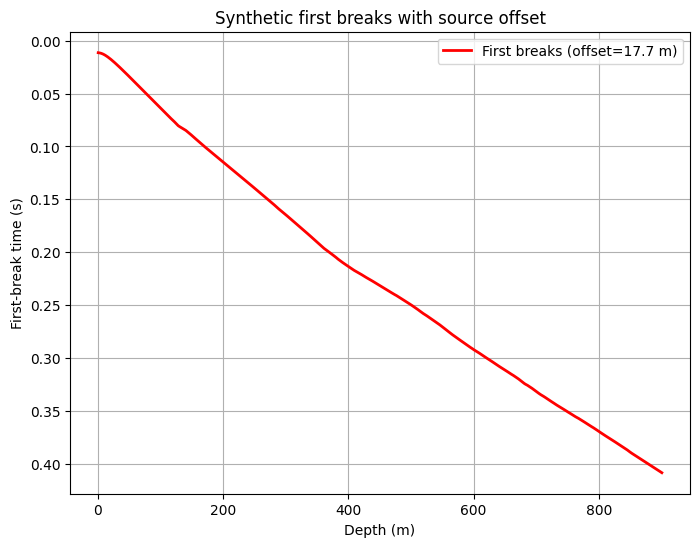

In [16]:
import numpy as np
import matplotlib.pyplot as plt

# depth (m) and velocity (m/s) from your sonic log
depth = depths
vel = interval_velocities

# cumulative one-way vertical time
dz = np.diff(depth)
v_mid = (vel[:-1] + vel[1:]) / 2.0
t_vert = np.concatenate([[0], np.cumsum(dz / v_mid)])

# average velocity to each depth
v_avg = depth / (t_vert + 1e-9)   # avoid div by zero at surface

# --- source geometry ---
x_src = 17.7   # horizontal offset in m (example)
z_src = 0.0     # source depth in m (0 = surface)

# compute first breaks
first_breaks_time = []
for zr, vav in zip(depth, v_avg):
    L = np.sqrt(x_src**2 + (zr - z_src)**2)   # straight-line path
    t = L / vav
    first_breaks_time.append(t)

first_breaks_time = np.array(first_breaks_time)

# convert to sample indices
dt = 0.001
first_breaks_idx = (first_breaks_time / dt).astype(int)

# --- plot ---
plt.figure(figsize=(8,6))
plt.plot(depth, first_breaks_time, 'r-', lw=2, label=f"First breaks (offset={x_src} m)")
plt.gca().invert_yaxis()
plt.xlabel("Depth (m)")
plt.ylabel("First-break time (s)")
plt.title("Synthetic first breaks with source offset")
plt.grid(True); plt.legend()
plt.show()


Grid dimensions (nx, nz): 551 901


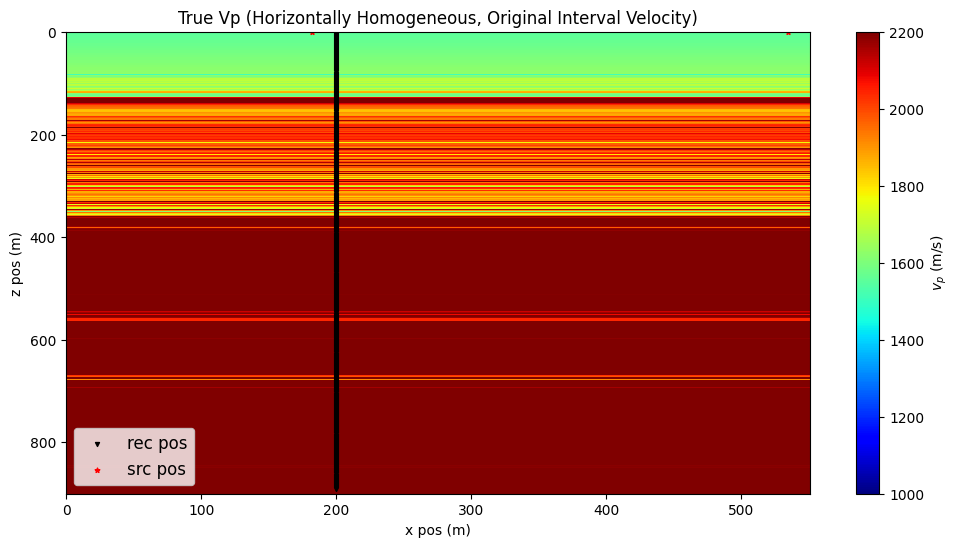

In [5]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import ndimage  # still used for smoothing

# ---- Grid (include endpoints) ----
ox, oz = 0.0, 0.0
dx, dz = 1.0, 1.0
x1, x2 = 0.0, 550.0
z1, z2 = 0.0, 900.0

x_grid = np.arange(x1, x2 + dx, dx)
z_grid = np.arange(z1, z2 + dz, dz)
nx, nz = x_grid.size, z_grid.size
print("Grid dimensions (nx, nz):", nx, nz)

# ---- Original interval velocity log from CSV ----
depths = df['Depth (DAS)'].values
interval_velocities = df['interval velocity'].values

# Sort (safety) and map to grid using nearest sample (no interp1d)
order = np.argsort(depths)
depths = depths[order]
interval_velocities = interval_velocities[order]

idx_nearest = np.abs(z_grid[:, None] - depths[None, :]).argmin(axis=1)
vel_1d = interval_velocities[idx_nearest]

# ---- Build 2D true velocity model ----
vel2d_true = np.tile(vel_1d, (nx, 1))  # shape (nx, nz)

# ---- Smoothed initial velocity model ----
vel2d_init = ndimage.gaussian_filter(vel2d_true, (20, 20), mode='nearest')

# ---- Receiver geometry ----
drec = 2.0
recz1 = 1.0
recz2 = 890.0 + drec
recx1 = 200.0
recz = np.arange(recz1, recz2, drec)
recx = np.full(recz.shape, recx1)
recs = np.column_stack([recx, recz])

# ---- Source geometry ----
srcx = np.array([182.3, 534.22])
srcz = np.full(srcx.shape, 1.0)
srcs = np.column_stack([srcx, srcz])

# ---- Plot ----
plotting.plot_model(
    vel2d_true,
    title="True Vp (Horizontally Homogeneous, Original Interval Velocity)",
    cbar=True,
    sampling=(dx, dz),
    origins=(ox, oz),
    cmap='jet',
    cbar_label='$v_p$ (m/s)',
    src_locations=srcs,
    rec_locations=recs,
    figsize=(12, 6),
    vlims=[1000, 2200]
)


In [6]:
dir_model = "./model/"
dir_seis  = "./seis/"

### Vp Model
np.array(vel2d_true,   dtype="float32").tofile(dir_model+"vp2d_true.bin")
np.array(vel2d_init,   dtype="float32").tofile(dir_model+"vp2d_init.bin")

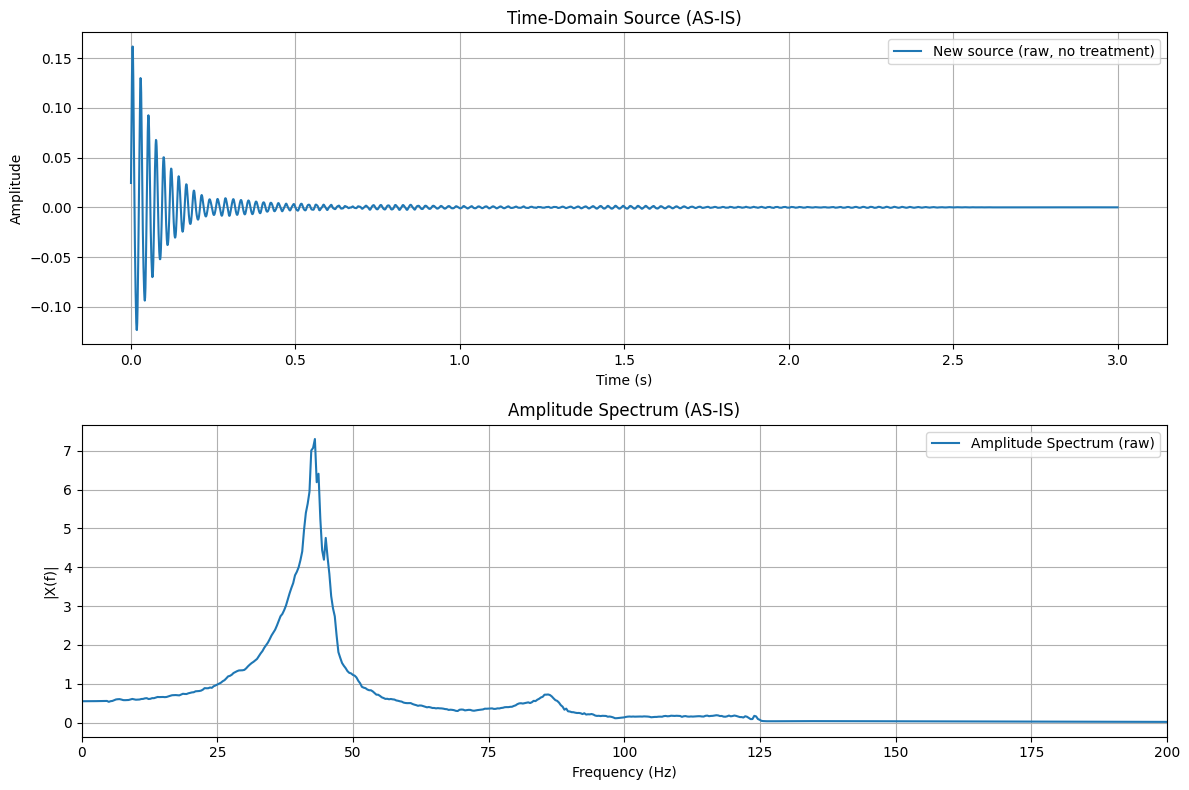

In [7]:
import numpy as np
import matplotlib.pyplot as plt

# -------- params --------
file_path1 = "source_pilot_run3_raw.bin"
nt = 3001
dt = 0.001
nt_new = 3001   # keep same length; no extra padding applied

# -------- load raw --------
data1 = np.fromfile(file_path1, dtype=np.float32).astype(np.float64, copy=False)
if len(data1) < nt:
    raise ValueError(f"File has {len(data1)} samples, but nt={nt} requested.")
data1_raw = data1[:nt]

# time axis
time_axis = np.arange(nt) * dt

# -------- use AS-IS (no treatment) --------
# If nt_new > nt we could right-pad with zeros; here nt_new == nt.
new_source = data1_raw.copy()

# -------- spectrum helper --------
def one_sided_spectrum(x, dt):
    X = np.fft.rfft(x)
    f = np.fft.rfftfreq(len(x), d=dt)
    return f, np.abs(X)

f_src, A_src = one_sided_spectrum(new_source, dt)


# the source funciton form

source_form = np.pad(data1_raw, (0, nt_new - nt), mode="constant")


# -------- plots --------
plt.figure(figsize=(12, 8))

# Time-domain (raw, as-is)
plt.subplot(2, 1, 1)
plt.plot(time_axis, new_source, label='New source (raw, no treatment)')
plt.title("Time-Domain Source (AS-IS)")
plt.xlabel("Time (s)"); plt.ylabel("Amplitude")
plt.grid(True); plt.legend()

# Spectrum (raw)
plt.subplot(2, 1, 2)
plt.plot(f_src, A_src, label='Amplitude Spectrum (raw)')
plt.title("Amplitude Spectrum (AS-IS)")
plt.xlabel("Frequency (Hz)"); plt.ylabel("|X(f)|")
plt.xlim(0, 200); plt.grid(True); plt.legend()

plt.tight_layout()
plt.show()


In [8]:
model_padding = (100,100)
# Sampling in the x and z directions (5m for both in this case)
model_sampling = (dx, dz)
# Origin of the model (0, 0)
model_origins = (ox, oz)

In [9]:
# simple NaN fill (vertical interpolation + neighbor copy)
def clean_velocity(v, v_floor=500.0):
    v = np.array(v, copy=True)
    nz, nx = v.shape
    z = np.arange(nz)
    for ix in range(nx):
        col = v[:, ix]
        m = np.isfinite(col)
        if m.any():
            v[:, ix] = np.interp(z, z[m], col[m])
        else:
            # copy from nearest valid column
            j = min([k for k in range(nx) if np.isfinite(v[:,k]).any()],
                    key=lambda k: abs(k-ix))
            v[:, ix] = v[:, j]
    return np.clip(v, v_floor, None).astype(np.float32)

vel2d_true = clean_velocity(vel2d_true)


In [10]:
# make 2d elastic wave equation solver
acoustic_2d_obs_base = acoustic_isotropic.AcousticIsotropic2D(
    model=vel2d_true,
    model_sampling=model_sampling,
    model_padding=model_padding,
    wavelet=source_form,
    d_t=dt,
    src_locations=srcs,
    rec_locations=recs,
    model_origins=model_origins,
    subsampling=40,
    gpus=[0])

In [11]:
%%time
data_obs_base_p = acoustic_2d_obs_base.forward(vel2d_true)

CPU times: user 18.3 s, sys: 8.09 s, total: 26.4 s
Wall time: 12.6 s


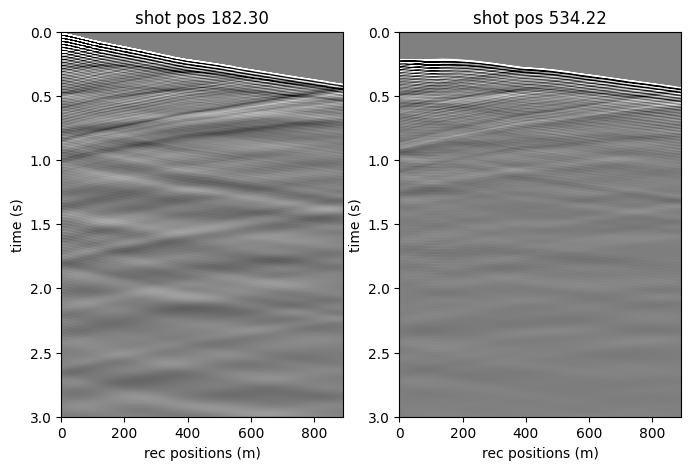

In [92]:
plotting.plot_data(np.squeeze(data_obs_base_p[:,:,:]),
                   dt,
                   n_shots=2,
                   figsize=(4, 5),
                   src_locations=srcx,
                   rec_locations=recz)

In [93]:
import numpy as np
import matplotlib.pyplot as plt

def plot_data(data,
              d_t,
              src_locations=None,
              rec_locations=None,
              n_shots=3,
              title='wavelet',
              figsize=(3, 5),
              pclip=99,
              clip=None,
              cmap='gray',
              ylabel='time (s)',
              xlabel='rec positions (m)',
              titles=None):
  fig, axs = plt.subplots(1,
                          n_shots,
                          figsize=(figsize[0] * n_shots, figsize[1]))

  skip = data.shape[0] // n_shots
  data = data[::skip]
  if src_locations is not None:
    src_locations = src_locations[::skip]
  if rec_locations is None:
    rec_locations = np.arange(data.shape[1])
    xlabel = 'rec #'
    
  t_axis = d_t * np.arange(data.shape[-1])

  if clip is None:
    clip = np.percentile(np.abs(data), pclip)
  for i, (ax, shot) in enumerate(zip(axs, data)):
    ax.pcolormesh(rec_locations,
                  t_axis,
                  shot.T,
                  shading='nearest',
                  vmin=-clip,
                  vmax=clip,
                  cmap=cmap)
    ax.invert_yaxis()

    # ---- Limit time axis to 0–1 s ----
    ax.set_ylim(1.0, 0.0)

    # ---- CUSTOM TITLES ----
    if titles is not None:
      ax.set_title(titles[i])
    elif src_locations is None:
      ax.set_title(f'shot# {i*skip}')
    else:
      ax.set_title(f'shot pos %.2f' % src_locations[i])

    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)

    # Optional: ticks every 0.1 s
    ax.set_yticks(np.arange(0, 1.01, 0.1))


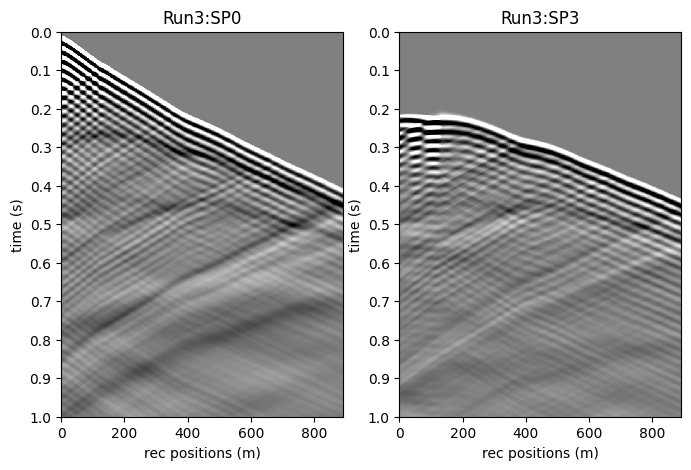

In [94]:
custom_titles = ["Run3:SP0", "Run3:SP3"]

plot_data(np.squeeze(data_obs_base_p[:,:,:]),
          dt,
          n_shots=2,
          figsize=(4, 5),
          src_locations=srcx,
          rec_locations=recz,
          titles=custom_titles)


In [96]:
# Assume data_obs_base_p has shape (n_shots, n_receivers, n_samples)
first_shot = np.squeeze(data_obs_base_p[0, :, :])   # shape: (n_receivers, n_samples)

# Save to binary
first_shot.astype(np.float32).tofile("Data_Run3_SP0.bin")




In [97]:
data_obs_base_p[0, :, :].shape

(446, 3001)

In [98]:
nr, nt = 446, 3001
loaded_shot = np.fromfile("Data_Run3_SP0.bin", dtype=np.float32).reshape(nr, nt)


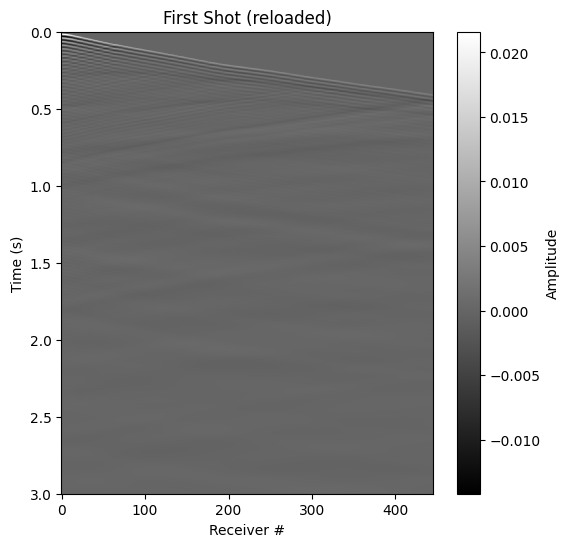

In [101]:
import numpy as np
import matplotlib.pyplot as plt

# dimensions
nr, nt = 446, 3001
dt = 0.001  # sample interval [s]

# reload the binary file
shot0 = np.fromfile("Data_Run3_SP0.bin", dtype=np.float32).reshape(nr, nt)

# build axes
time_axis = np.arange(nt) * dt
rec_axis = np.arange(nr)

# plot
plt.figure(figsize=(6, 6))
plt.pcolormesh(rec_axis, time_axis, shot0.T,
               shading='nearest', cmap='gray')
plt.gca().invert_yaxis()
plt.title("First Shot (reloaded)")
plt.xlabel("Receiver #")
plt.ylabel("Time (s)")
plt.colorbar(label="Amplitude")
plt.show()


In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Example: depth (m) and velocity (m/s) arrays from your model/log
depths = np.array([0, 400, 750, 968])        # layer boundaries
velocities = np.array([800, 1200, 1500])     # layer velocities

# Compute cumulative travel times (one-way)
first_breaks_time = []
receivers_depth = np.arange(50, 969, 10)  # synthetic DAS channels at every 10 m

for z in receivers_depth:
    t = 0.0
    for i in range(len(velocities)):
        z0, z1 = depths[i], depths[i+1]
        if z > z1:
            t += (z1 - z0) / velocities[i]
        else:
            t += (z - z0) / velocities[i]
            break
    first_breaks_time.append(t)

first_breaks_time = np.array(first_breaks_time)

# Convert to sample index if dt known
dt = 0.001  # s
first_breaks_idx = (first_breaks_time / dt).astype(int)

print("First break times (s):", first_breaks_time[:10])
print("First break indices:", first_breaks_idx[:10])

# Plot
plt.figure(figsize=(6,4))
plt.plot(receivers_depth, first_breaks_time, 'o-')
plt.gca().invert_yaxis()
plt.xlabel("Receiver depth (m)")
plt.ylabel("First break time (s)")
plt.title("Synthetic first-break curve from 1D model")
plt.grid(True)
plt.show()
